## Learning about Pystan

Sources:
- [An Introduction to Bayesian Inference in Pystan](https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import pystan

In [3]:
# Stan model specification

model = """

data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(alpha + beta*x, sigma);
}
"""

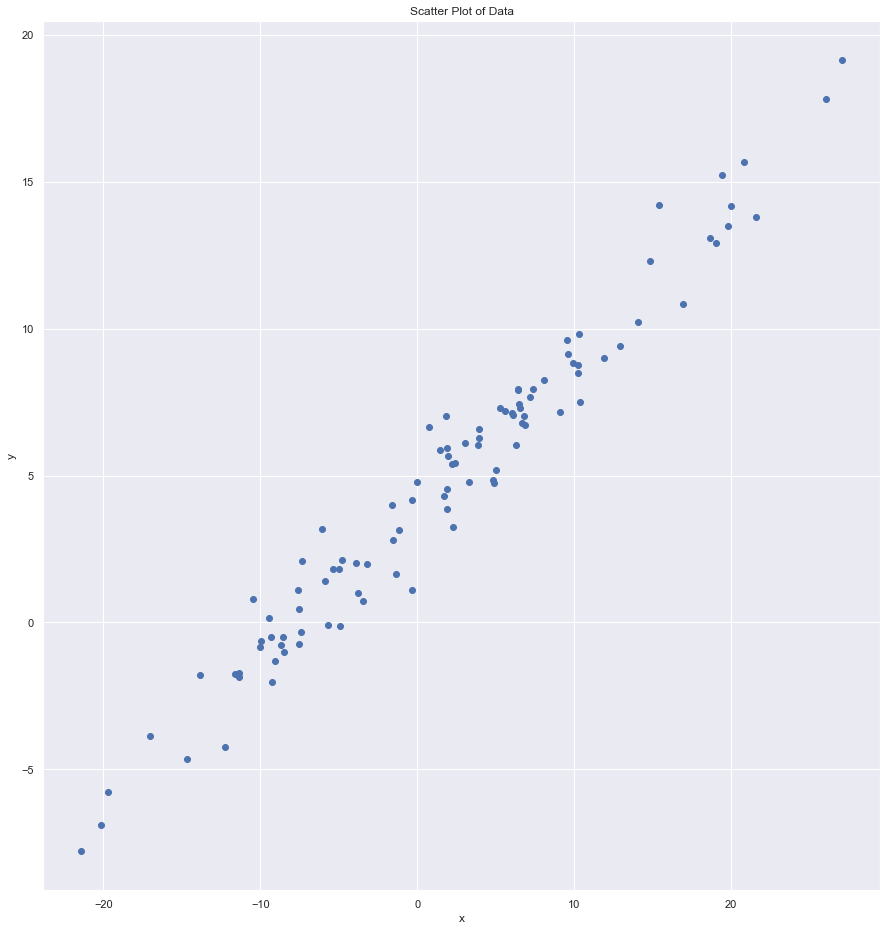

In [4]:
# Data generation

# Set seed for reproducibility
np.random.seed(101)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot
x = 10 * np.random.randn(100)
y = alpha + beta * x
y = np.random.normal(y, scale = sigma)

plt.figure(figsize=(15,16))

plt.scatter(x,y)

plt.title('Scatter Plot of Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
# Put data in a dictionary
data = {'N' : len(x), 
        'x' : x,
        'y' : y}

# Compile model
sm = pystan.StanModel(model_code = model)

# Train model and generate samples
fit = sm.sampling(data=data, 
                 iter=1000, 
                 chains=4, 
                 warmup=500,
                 thin=1,
                 seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d1e6a3398ed08f7d9ea6b711bb5865bd NOW.


In [6]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'],
                 columns = summary_dict['summary_colnames'],
                 index = summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting Traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

Text(0.5, 1.0, 'Fitted Regression Line')

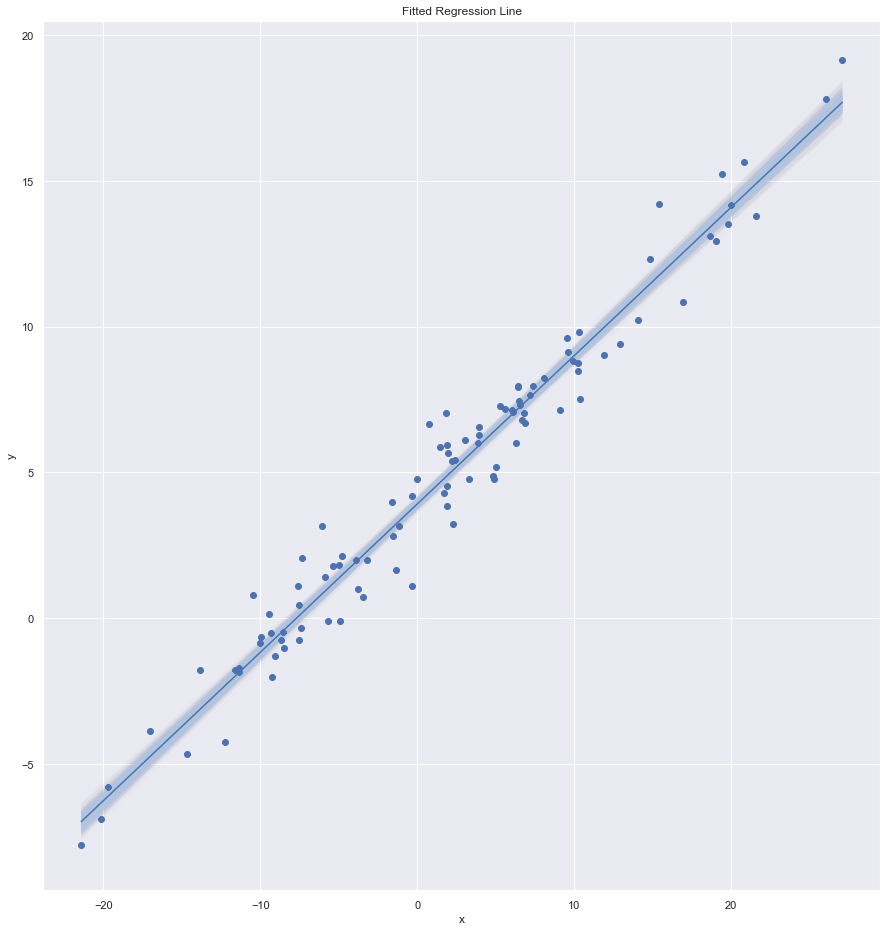

In [7]:
# Plotting regression line
x_max, x_min = np.max(x), np.min(x)
x_plot = np.linspace(x_min, x_max, 100)

# Plot subset of sampled regression lines
plt.figure(figsize=(15,16))
np.random.shuffle(alpha), np.random.shuffle(beta)

for i in range(1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, 
            color = 'lightsteelblue',
            alpha = 0.005)

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Line')

In [8]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter"""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.figure(figsize=(17,21))
    
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color = 'r', lw = 2, linestyle = '--')
    plt.axhline(median, color = 'c', lw = 2, linestyle = '--')
    plt.axhline(cred_min, color = 'k', linestyle = ':', alpha = 0.2)
    plt.axhline(cred_max, color = 'k', linestyle = ':', alpha = 0.2)
    plt.title(f'Trace and Posterior Distribution for {param_name}')
    
    plt.subplot(2,1,2)
    plt.hist(param, 30, density = True); sns.kdeplot(param, shade = True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color = 'r', lw = 2, linestyle = '--', label = 'mean')
    plt.axvline(median, color = 'c', lw = 2, linestyle = '--', label = 'median')
    plt.axvline(cred_min, color = 'k', linestyle = ':', alpha = 0.2, label = '95% CI')
    plt.axvline(cred_max, color = 'k', linestyle = ':', alpha = 0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

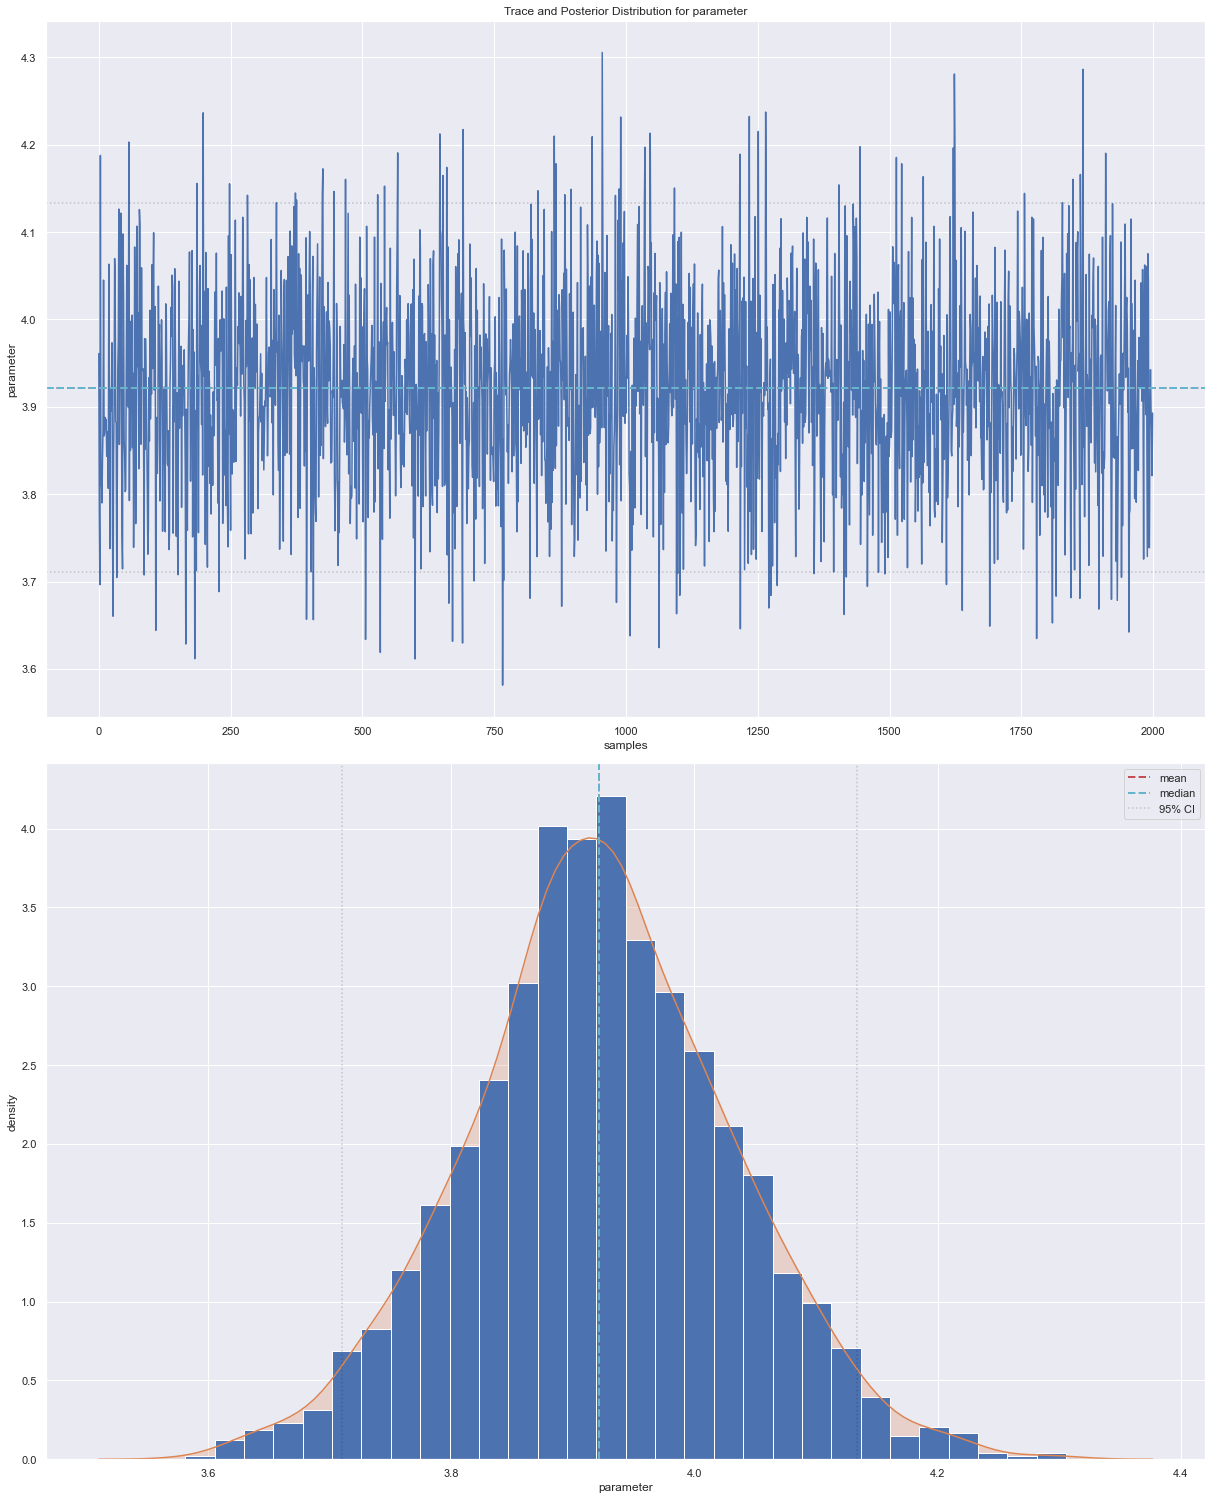

In [9]:
plot_trace(alpha, param_name='parameter')

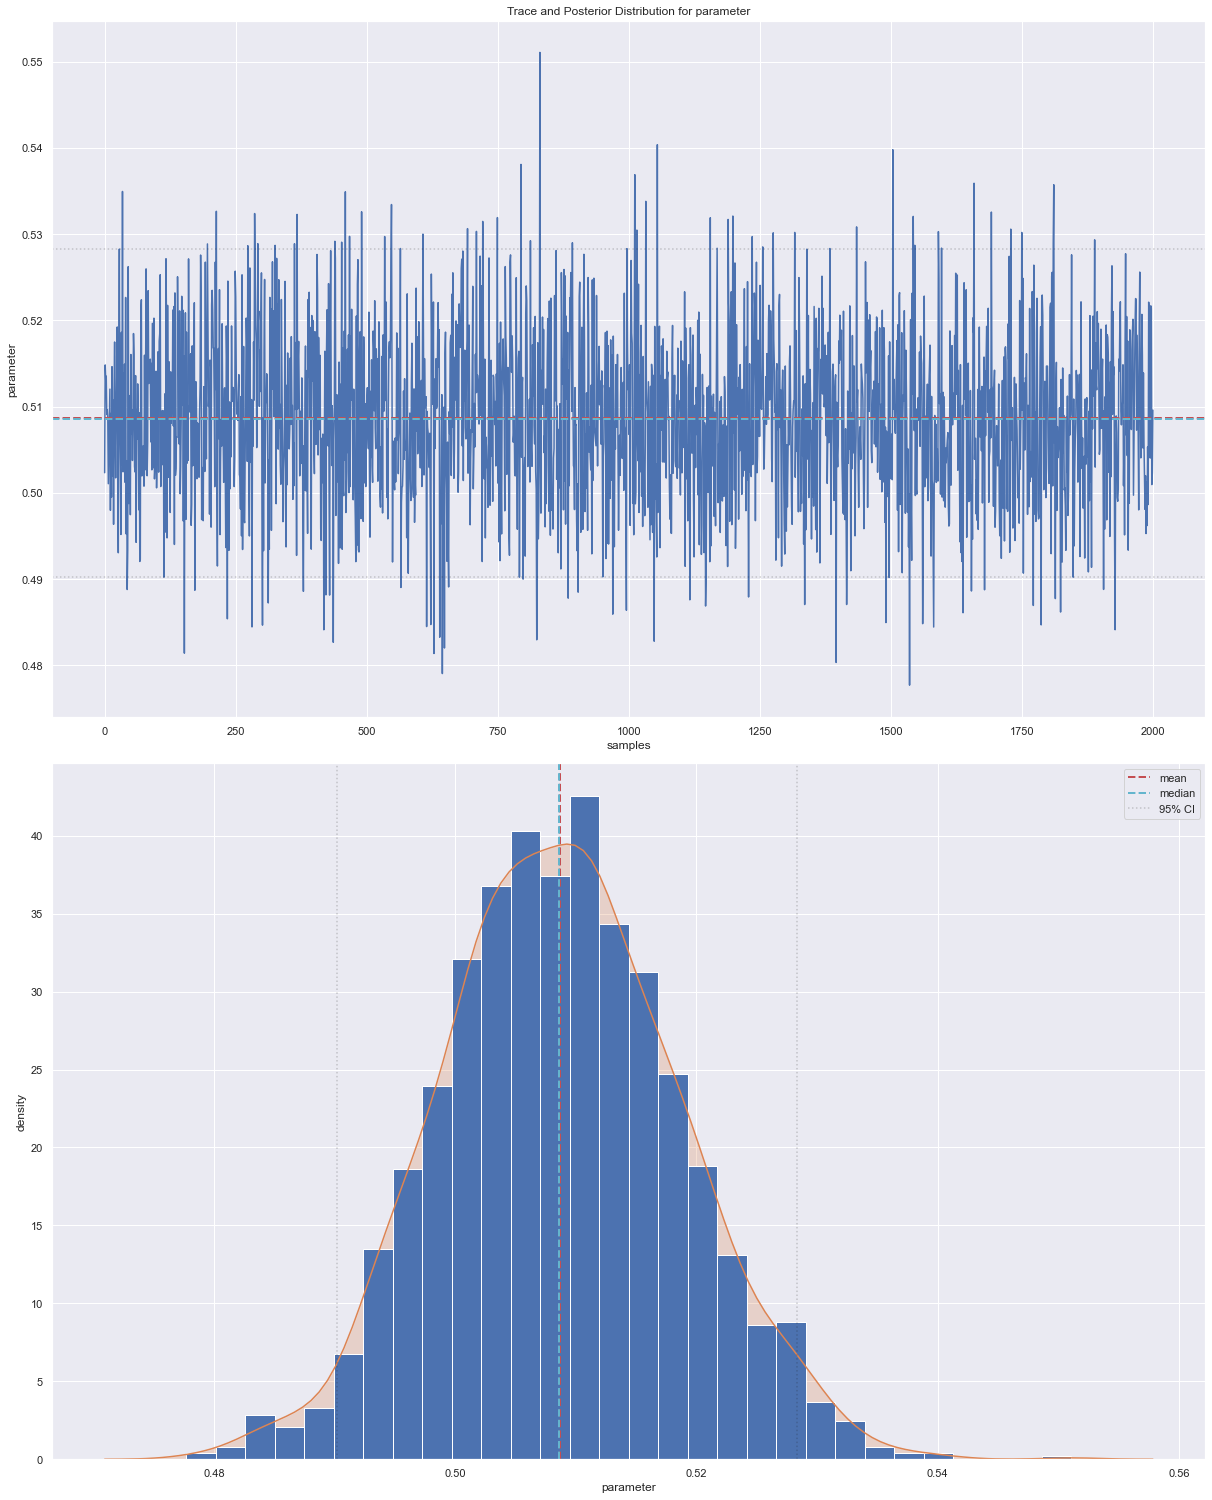

In [10]:
plot_trace(beta, param_name='parameter')